# Transfer Learning

## Importing Module

In [1]:
import os
import random
import zipfile
import urllib.request
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from keras_preprocessing.image import ImageDataGenerator

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## PROBLEM A3
- Build a classifier for the Human or Horse Dataset with Transfer Learning.
- The test will expect it to classify binary classes.
- Note that all the layers in the pre-trained model are non-trainable.
- Do not use lambda layers in your model.
- The horse-or-human dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
- Inception_v3, pre-trained model used in this problem is developed by Google.
- Desired accuracy and validation_accuracy > `97%`.

### Prepare Data

In [2]:
data_url_1 = 'https://github.com/dicodingacademy/assets/releases/download/release-horse-or-human/horse-or-human.zip'
data_url_2 = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/validation-horse-or-human.zip'

train_dir = Path('data/horse-or-human')
val_dir = Path('data/validation-horse-or-human')


list_files = {
    'file_1' : ['horse-or-human.zip', data_url_1, train_dir],
    'file_2' : ['validation-horse-or-human.zip', data_url_2, val_dir]
}

### Download Weight Base Model

In [3]:
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

if os.path.isfile(local_weights_file) == False:
  urllib.request.urlretrieve(inceptionv3, local_weights_file)
  print(f'{local_weights_file} Downloaded')
else:
  print(f'{local_weights_file} Already exist')


inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 Downloaded


### Download and Extract Data

In [4]:
for data_file in list_files.values():
  try:
    if os.path.isfile(data_file[0]) == False:
      urllib.request.urlretrieve(data_file[1], data_file[0])
      zip_ref = zipfile.ZipFile(data_file[0], 'r')
      zip_ref.extractall(data_file[2])
      zip_ref.close()
      print(f'{data_file[0]} Download and Extract finished')
    else:
      print(f'{data_file[0]} Already exist')
  except ValueError as e:
    print(e)

horse-or-human.zip Download and Extract finished
validation-horse-or-human.zip Download and Extract finished


In [5]:
train_data_path = os.listdir(train_dir)
validation_data_path = os.listdir(val_dir)

image_count = len(list(train_dir.glob("*/*")))
print(f'Total Image in {train_dir} : {image_count}')
for i in train_data_path:
  target_path = os.path.join(train_dir, i)
  print(f'Total Train Images in {i} : {len(os.listdir(target_path))}')

print()

val_image_count = len(list(val_dir.glob("*/*")))
print(f'Total Image in {val_dir} : {val_image_count}')
for i in validation_data_path:
  target_path = os.path.join(val_dir, i)
  print(f'Total Validation Images in {i} : {len(os.listdir(target_path))}')

Total Image in data/horse-or-human : 1027
Total Train Images in humans : 527
Total Train Images in horses : 500

Total Image in data/validation-horse-or-human : 256
Total Validation Images in humans : 128
Total Validation Images in horses : 128


### Set Params

In [6]:
IMG_SIZE = (150,150)
BATCH_SIZE = 128
desired_accuracy = 0.97

### Load Image

In [7]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

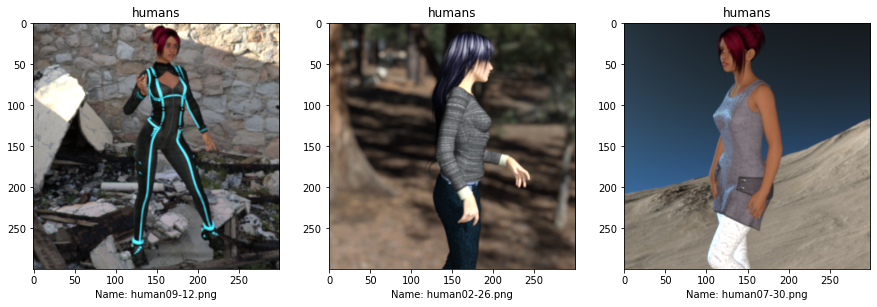

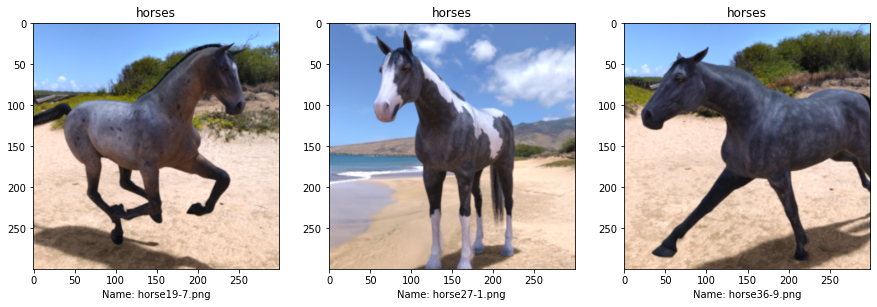

In [8]:
for dir in train_data_path:
  image_dir = os.path.join(train_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Create ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
     rescale=1./255,
     zoom_range=0.1,
     rotation_range=20, 
     horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary')


test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE//4,
    shuffle = True,
    class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


### Base Model

In [10]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=None)

In [11]:
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
        layer.trainable = False

In [12]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [13]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

### Create Model

In [14]:
def create_model(last_output):
  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(units=512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

  model = tf.keras.Model(pre_trained_model.input, x)

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"])
  
  return model

In [15]:
model = create_model(last_output)
print(f"Model : {model}")

Model : <keras.engine.functional.Functional object at 0x7effc2280850>


### Create Custom Callbacks

In [16]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Train Model

In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[custom_callback],
      validation_steps=8)

Epoch 1/10
8/8 [==============================] - 25s 1s/step - loss: 0.1579 - accuracy: 0.9210 - val_loss: 0.0175 - val_accuracy: 0.9961
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9956
Training accuracy was > 97.0%, stop training...
8/8 [==============================] - 10s 1s/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 0.0342 - val_accuracy: 0.9961


## PROBLEM B3

- Build a CNN based classifier for Rock-Paper-Scissors dataset.
- Your input layer should accept `150x150` with 3 bytes color as the input shape.
- This is unlabeled data, use ImageDataGenerator to automatically label it.
- Don't use lambda layers in your model.
- The dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
- Desired accuracy AND validation_accuracy > `83%`

### Prepare Data

In [18]:
data_url = 'https://github.com/dicodingacademy/assets/releases/download/release-rps/rps.zip'

name_file = 'rps.zip'
target_path = 'data/'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  zip_ref = zipfile.ZipFile(name_file, 'r')
  zip_ref.extractall(target_path)
  zip_ref.close()
  print(f'{name_file} Download and Extract finished')
else:
  print(f'{name_file} Already exist')

rps.zip Download and Extract finished


In [19]:
base_dir = Path('./data/rps/')

list_dir = os.listdir(base_dir)
image_count = len(list(base_dir.glob("*/*")))
print(f'Total Image : {image_count}\n')
for dir in list_dir:
  image_count_dir = len(list(base_dir.glob(f'{dir}/*')))
  print(f'{dir} : {image_count_dir}')

Total Image : 2520

rock : 840
scissors : 840
paper : 840


### Set Params

In [20]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64
desired_accuracy = 0.83

### Plot Image

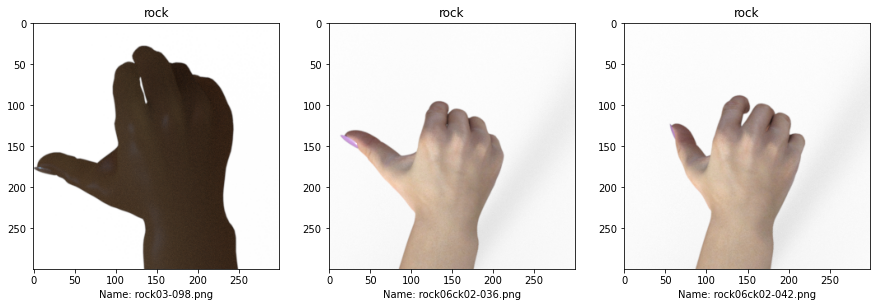

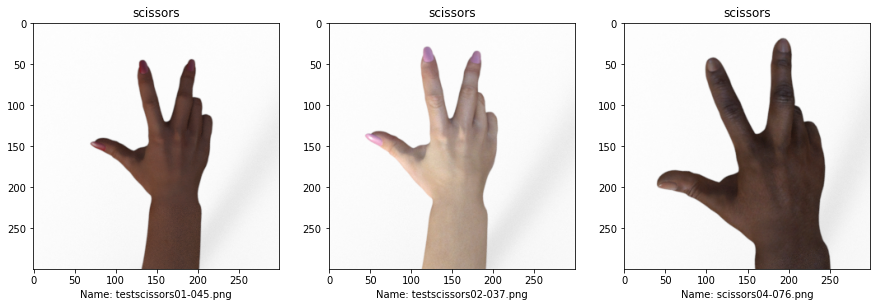

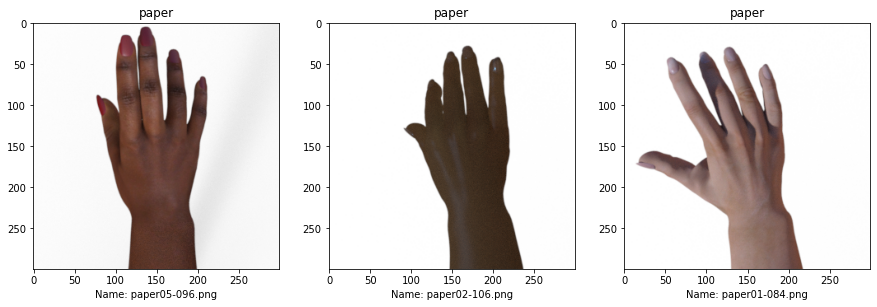

In [21]:
for dir in list_dir:
  image_dir = os.path.join(base_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Create ImageDataGenerator

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   shear_range = 0.2, 
                                   horizontal_flip=True, 
                                   fill_mode = 'wrap',
                                   validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
    base_dir,  
    target_size=IMG_SIZE,  
    shuffle = True,
    subset='training',
    batch_size = BATCH_SIZE,
    class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)

validation_generator = test_datagen.flow_from_directory(
    base_dir, 
    target_size=(150, 150),  
    subset='validation', 
    batch_size = BATCH_SIZE//2,
    class_mode='categorical')

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


In [23]:
def create_model():
  '''Creates a CNN with convolutional layers'''

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=IMG_SIZE + (3,)))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.7))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"])
  
  return model

In [24]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7eff8bb4c350>


### Create Custom Callbakcs

In [25]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Train Model

In [26]:
history = model.fit(
      train_generator,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[custom_callback])

Epoch 1/20
32/32 [==============================] - 19s 500ms/step - loss: 1.0903 - accuracy: 0.3686 - val_loss: 1.0202 - val_accuracy: 0.4683
Epoch 2/20
32/32 [==============================] - 16s 494ms/step - loss: 0.6637 - accuracy: 0.7088 - val_loss: 0.4749 - val_accuracy: 0.8135
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.9092
Training accuracy was > 83.0%, stop training...
32/32 [==============================] - 16s 499ms/step - loss: 0.2530 - accuracy: 0.9092 - val_loss: 0.2689 - val_accuracy: 0.9028


### Plot result

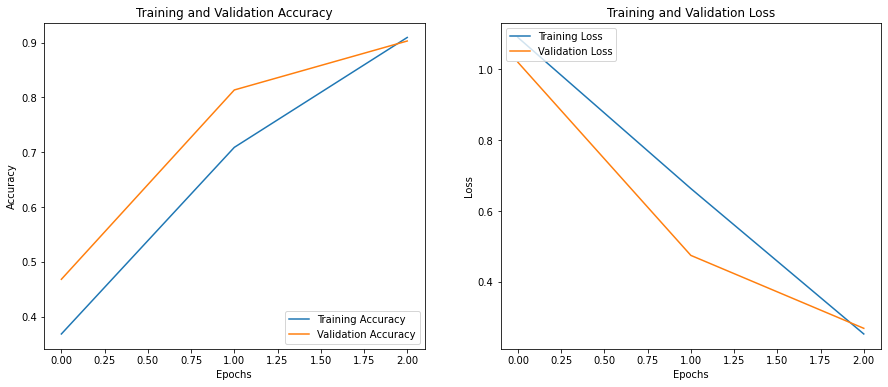

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Build a CNN based classifier for Cats vs Dogs dataset.
- Your input layer should accept `150x150` with 3 bytes color as the input shape.
- This is unlabeled data, use ImageDataGenerator to automatically label it.
- Don't use lambda layers in your model.

- The dataset used in this problem is originally published in https://www.kaggle.com/c/dogs-vs-cats/data
- Desired accuracy and validation_accuracy > `72%`

### Prepare Data

In [28]:
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/cats_and_dogs.zip'

name_file = 'cats_and_dogs.zip'
target_path = 'data/'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  zip_ref = zipfile.ZipFile(name_file, 'r')
  zip_ref.extractall(target_path)
  zip_ref.close()
  print(f'{name_file} Download and Extract finished')
else:
  print(f'{name_file} Already exist')

cats_and_dogs.zip Download and Extract finished


In [29]:
base_dir = Path('./data/cats_and_dogs_filtered/')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

list_dir = os.listdir(base_dir)

image_count = len(list(base_dir.glob("*/*/*")))
print(f'Total Image : {image_count}\n')
for dir in list_dir[1:]:
  image_count_dir = len(list(base_dir.glob(f'{dir}/*/*.jpg')))
  print(f'Total Image {dir} : {image_count_dir}')
  image_dir = os.path.join(base_dir, dir)
  for i in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, i)
    class_dir = os.listdir(class_dir)
    print(f'{i} : {len(class_dir)}')


Total Image : 3000

Total Image validation : 1000
dogs : 500
cats : 500
Total Image train : 2000
dogs : 1000
cats : 1000


### Set Params

In [30]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64
desired_accuracy = 0.72

### Plot Image

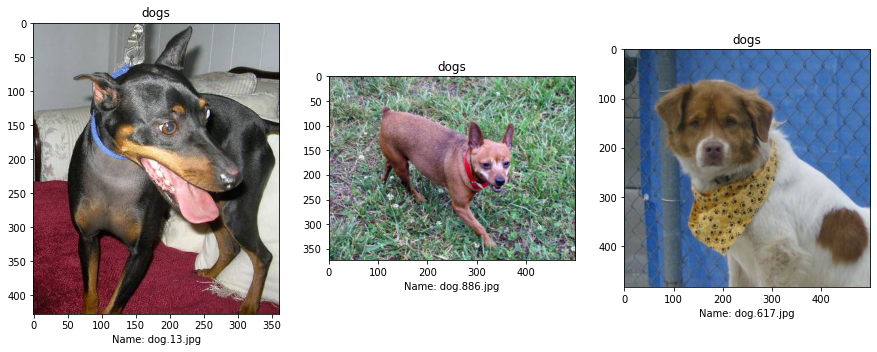

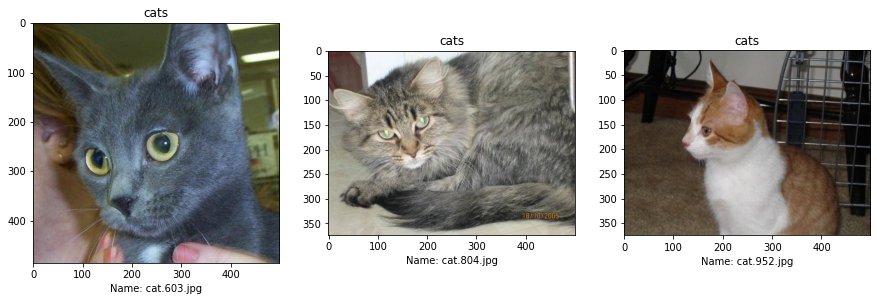

In [31]:
for dir in os.listdir(train_dir):
  image_dir = os.path.join(train_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Create ImageDataGenerator

In [32]:
train_datagen = ImageDataGenerator(
     rotation_range=15,
     rescale=1./255,
     shear_range=0.1,
     zoom_range=0.2,
     horizontal_flip=True,
     width_shift_range=0.1,
     height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='binary')


test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE//2,
    shuffle = True,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Build Model

In [33]:
def create_model():
  '''Creates a CNN with convolutional layers'''

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=IMG_SIZE + (3,)))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))

  model.add(tf.keras.layers.Flatten())
  # model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"])
  
  return model

In [34]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f003d324f90>


### Create Custom Callbakcs

In [35]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('accuracy') > desired_accuracy and logs.get('val_accuracy') > desired_accuracy:
                print(f'\nTraining accuracy was > {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

### Train Model

In [36]:
history = model.fit(
      train_generator,
      steps_per_epoch=2000//100,
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      callbacks=[custom_callback],
      validation_steps=1000//100)

Epoch 1/50
20/20 [==============================] - 10s 495ms/step - loss: 0.6994 - accuracy: 0.5373 - val_loss: 0.6844 - val_accuracy: 0.4781
Epoch 2/50
20/20 [==============================] - 10s 520ms/step - loss: 0.6697 - accuracy: 0.5891 - val_loss: 0.6780 - val_accuracy: 0.5469
Epoch 3/50
20/20 [==============================] - 10s 492ms/step - loss: 0.6349 - accuracy: 0.6273 - val_loss: 0.6193 - val_accuracy: 0.6969
Epoch 4/50
20/20 [==============================] - 9s 473ms/step - loss: 0.6437 - accuracy: 0.6258 - val_loss: 0.5809 - val_accuracy: 0.7000
Epoch 5/50
20/20 [==============================] - 9s 472ms/step - loss: 0.6009 - accuracy: 0.6899 - val_loss: 0.5533 - val_accuracy: 0.7063
Epoch 6/50
20/20 [==============================] - 9s 472ms/step - loss: 0.6093 - accuracy: 0.6518 - val_loss: 0.5791 - val_accuracy: 0.7031
Epoch 7/50
20/20 [==============================] - 10s 481ms/step - loss: 0.5841 - accuracy: 0.6956 - val_loss: 0.5990 - val_accuracy: 0.6594
Ep

### Plot Result

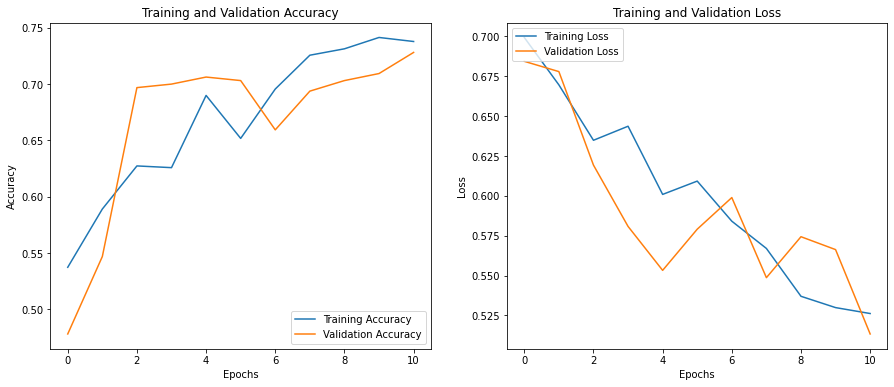

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()